In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/data/processed"

print("✅ Dataset folder exists:", os.path.exists(DATASET_DIR))
print("Subfolders:", len(os.listdir(DATASET_DIR)))

# Show a few samples
for i, folder in enumerate(os.listdir(DATASET_DIR)[:3]):
    frames_path = os.path.join(DATASET_DIR, folder, "frames")
    if os.path.exists(frames_path):
        print(f"{i+1}. {folder} → {len(os.listdir(frames_path))} frames")

Mounted at /content/drive
✅ Dataset folder exists: True
Subfolders: 1000
1. no370_xvid → 41 frames
2. fi104_xvid → 41 frames
3. fi101_xvid → 41 frames


In [ ]:
!pip install torch torchvision timm opencv-python librosa matplotlib tqdm

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

class RPATDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.video_folders = [
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        folder = self.video_folders[idx]
        frames_dir = os.path.join(folder, "frames")
        frame_files = sorted(os.listdir(frames_dir))
        mid_frame = frame_files[len(frame_files)//2]
        image = Image.open(os.path.join(frames_dir, mid_frame)).convert("RGB")

        # label.txt must contain “violent” or “non_violent”
        with open(os.path.join(folder, "label.txt")) as f:
            text = f.read().strip().lower()
        label = 1 if "violent" in text else 0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = RPATDataset(DATASET_DIR, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

print("✅ Total videos:", len(dataset))
for imgs, labels in train_loader:
    print("Sample batch:", imgs.shape, labels)
    break

✅ Total videos: 1000
Sample batch: torch.Size([8, 3, 224, 224]) tensor([1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
import torch.nn as nn
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on", device)

# Pretrained Vision Transformer backbone
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.head = nn.Linear(model.head.in_features, 2)   # binary classifier
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print("✅ Model ready.")

Running on cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Model ready.


In [ ]:
  !pip install opencv-python

In [ ]:
from tqdm import tqdm

epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f} | Acc={acc:.3f}")

Epoch 1/3: 100%|██████████| 125/125 [47:02<00:00, 22.58s/it]


Epoch 1: Loss=0.0059 | Acc=0.996


Epoch 2/3: 100%|██████████| 125/125 [29:38<00:00, 14.23s/it]


Epoch 2: Loss=0.0000 | Acc=1.000


Epoch 3/3: 100%|██████████| 125/125 [29:38<00:00, 14.23s/it]

Epoch 3: Loss=0.0000 | Acc=1.000


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

class RPATMotionDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=3):
        self.root_dir = root_dir
        self.video_folders = [
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        folder = self.video_folders[idx]
        frames_dir = os.path.join(folder, "frames")
        frame_files = sorted(os.listdir(frames_dir))
        mid = len(frame_files)//2

        # pick surrounding frames
        start = max(0, mid - self.num_frames//2)
        end = min(len(frame_files), start + self.num_frames)
        selected = frame_files[start:end]

        # load frames
        frames = [cv2.cvtColor(cv2.imread(os.path.join(frames_dir, f)), cv2.COLOR_BGR2RGB) for f in selected]

        # compute frame difference
        diffs = []
        for i in range(len(frames)-1):
            diff = cv2.absdiff(frames[i+1], frames[i])
            diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
            diffs.append(diff)

        motion_map = np.mean(np.stack(diffs, axis=0), axis=0)  # avg motion intensity
        motion_map = np.expand_dims(motion_map, axis=-1).repeat(3, axis=-1)  # 3-channel

        # choose mid-frame as RGB image
        image = frames[len(frames)//2]
        image = Image.fromarray(image)
        motion_image = Image.fromarray(motion_map.astype(np.uint8))

        with open(os.path.join(folder, "label.txt")) as f:
            label = 1 if "violent" in f.read().lower() else 0

        if self.transform:
            image = self.transform(image)
            motion_image = self.transform(motion_image)

        # concatenate: [RGB + Motion] → 6 channels
        combined = torch.cat((image, motion_image), dim=0)
        return combined, torch.tensor(label)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

motion_dataset = RPATMotionDataset(DATASET_DIR, transform=transform)
motion_loader = DataLoader(motion_dataset, batch_size=4, shuffle=True)

imgs, labels = next(iter(motion_loader))
print("Input shape:", imgs.shape)  # expect (B, 6, 224, 224)

Input shape: torch.Size([4, 6, 224, 224])


In [ ]:
import torch.nn.functional as F

class ViT_MEPE(nn.Module):
    def __init__(self, pretrained_name="vit_base_patch16_224", num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(pretrained_name, pretrained=True)
        in_ch = 6  # 3 (RGB) + 3 (Motion)
        self.backbone.patch_embed.proj = nn.Conv2d(
            in_ch,
            self.backbone.patch_embed.proj.out_channels,
            kernel_size=self.backbone.patch_embed.proj.kernel_size,
            stride=self.backbone.patch_embed.proj.stride,
        )
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT_MEPE().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print("✅ MEPE-enabled ViT ready.")

✅ MEPE-enabled ViT ready.


In [ ]:
from tqdm import tqdm

epochs = 3
for epoch in range(epochs):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for imgs, labels in tqdm(motion_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss/len(motion_loader):.4f} | Acc={acc:.3f}")

Epoch 1/3: 100%|██████████| 250/250 [44:47<00:00, 10.75s/it]


Epoch 1: Loss=0.0023 | Acc=1.000


Epoch 2/3: 100%|██████████| 250/250 [32:35<00:00,  7.82s/it]


Epoch 2: Loss=0.0000 | Acc=1.000


Epoch 3/3: 100%|██████████| 250/250 [32:49<00:00,  7.88s/it]

Epoch 3: Loss=0.0000 | Acc=1.000


In [ ]:
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.7 MB/s eta 0:00:

In [ ]:
import mediapipe as mp
import numpy as np
import cv2
from PIL import Image

mp_pose = mp.solutions.pose

def get_pose_mask(image, size=(224, 224)):
    image_rgb = np.array(image)
    h, w, _ = image_rgb.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    with mp_pose.Pose(static_image_mode=True) as pose:
        results = pose.process(image_rgb)
        if results.pose_landmarks:
            for lm in results.pose_landmarks.landmark:
                cx, cy = int(lm.x * w), int(lm.y * h)
                cv2.circle(mask, (cx, cy), 8, 255, -1)

    mask = cv2.GaussianBlur(mask, (15,15), 0)
    mask = cv2.resize(mask, size)
    mask = mask / 255.0
    return mask

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


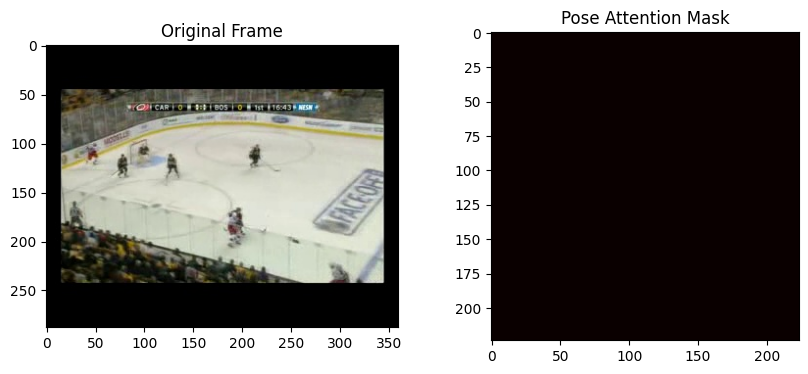

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to your processed dataset
DATASET_DIR = "/content/drive/MyDrive/data/processed"

# Pick a random sample folder manually
sample_folder = os.path.join(DATASET_DIR, os.listdir(DATASET_DIR)[0])
frames_dir = os.path.join(sample_folder, "frames")

# Pick a middle frame
frame_files = sorted(os.listdir(frames_dir))
mid_frame = frame_files[len(frame_files)//2]

# Load and visualize
image_path = os.path.join(frames_dir, mid_frame)
image = Image.open(image_path).convert("RGB")

# Generate pose mask
mask = get_pose_mask(image)

# Show the results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Frame")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='hot')
plt.title("Pose Attention Mask")
plt.show()


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import cv2
import numpy as np
import os


In [ ]:
class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=3):
        self.root_dir = root_dir
        self.video_folders = [
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        folder = self.video_folders[idx]
        frames_dir = os.path.join(folder, "frames")
        frame_files = sorted(os.listdir(frames_dir))
        mid = len(frame_files)//2
        image_path = os.path.join(frames_dir, frame_files[mid])

        # --- Load RGB + Motion ---
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        motion_map = cv2.absdiff(img, cv2.GaussianBlur(img, (9,9), 0))
        motion_map = Image.fromarray(motion_map)

        # --- Pose mask ---
        pose_mask = get_pose_mask(Image.fromarray(img))
        pose_mask = np.expand_dims(pose_mask, axis=-1).repeat(3, axis=-1)
        pose_mask = Image.fromarray((pose_mask*255).astype(np.uint8))

        with open(os.path.join(folder, "label.txt")) as f:
            label = 1 if "violent" in f.read().lower() else 0

        if self.transform:
            img = self.transform(Image.fromarray(img))
            motion_map = self.transform(motion_map)
            pose_mask = self.transform(pose_mask)

        # Concatenate: RGB + Motion + Pose  (9 channels)
        combined = torch.cat((img, motion_map, pose_mask), dim=0)
        return combined, torch.tensor(label)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

pose_dataset = RPATPoseDataset("/content/drive/MyDrive/data/processed", transform=transform)
pose_loader = DataLoader(pose_dataset, batch_size=4, shuffle=True)

imgs, labels = next(iter(pose_loader))
print("Batch shape:", imgs.shape)

Batch shape: torch.Size([4, 9, 224, 224])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RelationalMemory(nn.Module):
    def __init__(self, mem_slots=4, head_size=64, input_size=512, num_heads=4):
        super(RelationalMemory, self).__init__()
        self.mem_slots = mem_slots
        self.head_size = head_size
        self.num_heads = num_heads
        self.d_model = head_size * num_heads

        # Initial memory (learnable)
        self.initial_memory = nn.Parameter(torch.randn(mem_slots, self.d_model))

        # Attention layers for memory updates
        self.query_proj = nn.Linear(self.d_model, self.d_model)
        self.key_proj = nn.Linear(input_size, self.d_model)
        self.value_proj = nn.Linear(input_size, self.d_model)
        self.output_proj = nn.Linear(self.d_model, self.d_model)

    def forward(self, x, memory=None):
        """
        x: (batch, seq_len, input_size)
        memory: (batch, mem_slots, d_model)
        """
        batch_size = x.size(0)
        seq_len = x.size(1)

        if memory is None:
            memory = self.initial_memory.unsqueeze(0).repeat(batch_size, 1, 1)

        # Project queries, keys, values
        Q = self.query_proj(memory)
        K = self.key_proj(x)
        V = self.value_proj(x)

        # Multi-head attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_size ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, V)

        # Update memory
        updated_memory = self.output_proj(context + memory)
        return updated_memory


In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=input_dim, nhead=8, dim_feedforward=1024)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=4)

        self.rel_memory = RelationalMemory(input_size=input_dim)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        """
        memory = None
        outputs = []
        for t in range(x.size(1)):
            frame_feat = x[:, t, :].unsqueeze(1)
            enc_out = self.transformer(frame_feat)
            memory = self.rel_memory(enc_out, memory)
            outputs.append(memory.mean(dim=1))

        final_feat = torch.stack(outputs, dim=1).mean(dim=1)
        logits = self.fc(final_feat)
        return logits


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RelationalMemory(nn.Module):
    def __init__(self, mem_slots=4, head_size=64, input_size=512, num_heads=4):
        super(RelationalMemory, self).__init__()
        self.mem_slots = mem_slots
        self.head_size = head_size
        self.num_heads = num_heads
        self.d_model = head_size * num_heads

        # Learnable initial memory
        self.initial_memory = nn.Parameter(torch.randn(mem_slots, self.d_model))

        # Linear projections
        self.query_proj = nn.Linear(self.d_model, self.d_model)
        self.key_proj = nn.Linear(input_size, self.d_model)
        self.value_proj = nn.Linear(input_size, self.d_model)
        self.output_proj = nn.Linear(self.d_model, self.d_model)

    def forward(self, x, memory=None):
        batch_size = x.size(0)

        if memory is None:
            memory = self.initial_memory.unsqueeze(0).repeat(batch_size, 1, 1)

        Q = self.query_proj(memory)
        K = self.key_proj(x)
        V = self.value_proj(x)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_size ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, V)

        updated_memory = self.output_proj(context + memory)
        return updated_memory


In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=input_dim, nhead=8, dim_feedforward=1024)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=4)
        self.rel_memory = RelationalMemory(input_size=input_dim)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        """
        memory = None
        outputs = []
        for t in range(x.size(1)):
            frame_feat = x[:, t, :].unsqueeze(1)
            enc_out = self.transformer(frame_feat)
            memory = self.rel_memory(enc_out, memory)
            outputs.append(memory.mean(dim=1))

        final_feat = torch.stack(outputs, dim=1).mean(dim=1)
        logits = self.fc(final_feat)
        return logits


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RPATTransformer(input_dim=512, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import cv2
import numpy as np
import os


In [ ]:
def get_pose_mask(image):
    """
    Dummy pose mask for now (can replace later with MediaPipe or HRNet output).
    It highlights central human regions roughly.
    """
    img = np.array(image)
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.float32)
    cy, cx = h // 2, w // 2
    mask[cy - h//4 : cy + h//4, cx - w//6 : cx + w//6] = 1.0
    return mask


In [ ]:
class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=3):
        self.root_dir = root_dir
        self.video_folders = [
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        folder = self.video_folders[idx]
        frames_dir = os.path.join(folder, "frames")
        frame_files = sorted(os.listdir(frames_dir))
        mid = len(frame_files)//2
        image_path = os.path.join(frames_dir, frame_files[mid])

        # --- Load RGB + Motion ---
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        motion_map = cv2.absdiff(img, cv2.GaussianBlur(img, (9,9), 0))
        motion_map = Image.fromarray(motion_map)

        # --- Pose mask ---
        pose_mask = get_pose_mask(Image.fromarray(img))
        pose_mask = np.expand_dims(pose_mask, axis=-1).repeat(3, axis=-1)
        pose_mask = Image.fromarray((pose_mask*255).astype(np.uint8))

        # --- Label ---
        label_path = os.path.join(folder, "label.txt")
        label = 0
        if os.path.exists(label_path):
            with open(label_path) as f:
                label = 1 if "violent" in f.read().lower() else 0

        # --- Transform ---
        if self.transform:
            img = self.transform(Image.fromarray(img))
            motion_map = self.transform(motion_map)
            pose_mask = self.transform(pose_mask)

        # Combine channels: RGB + Motion + Pose (9 total)
        combined = torch.cat((img, motion_map, pose_mask), dim=0)
        return combined, torch.tensor(label)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive


'Colab Notebooks'   data   data_processed   processed_data   rpat_models


In [ ]:
!ls /content/drive/MyDrive/data


audio		fi327_xvid.avi	no102_xvid.avi	   no32_xvid.avi
fi100_xvid.avi	fi328_xvid.avi	no103_xvid.avi	   no330_xvid.avi
fi101_xvid.avi	fi329_xvid.avi	no104_xvid.avi	   no331_xvid.avi
fi102_xvid.avi	fi32_xvid.avi	no105_xvid.avi	   no332_xvid.avi
fi103_xvid.avi	fi330_xvid.avi	no106_xvid.avi	   no333_xvid.avi
fi104_xvid.avi	fi331_xvid.avi	no107_xvid.avi	   no334_xvid.avi
fi105_xvid.avi	fi332_xvid.avi	no108_xvid.avi	   no335_xvid.avi
fi106_xvid.avi	fi333_xvid.avi	no109_xvid.avi	   no336_xvid.avi
fi107_xvid.avi	fi334_xvid.avi	no10_xvid.avi	   no337_xvid.avi
fi108_xvid.avi	fi335_xvid.avi	no110_xvid.avi	   no338_xvid.avi
fi109_xvid.avi	fi336_xvid.avi	no111_xvid.avi	   no339_xvid.avi
fi10_xvid.avi	fi337_xvid.avi	no112_xvid.avi	   no33_xvid.avi
fi110_xvid.avi	fi338_xvid.avi	no113_xvid.avi	   no340_xvid.avi
fi111_xvid.avi	fi339_xvid.avi	no114_xvid.avi	   no341_xvid.avi
fi112_xvid.avi	fi33_xvid.avi	no115_xvid.avi	   no342_xvid.avi
fi113_xvid.avi	fi340_xvid.avi	no116_xvid.avi	   no343_xvid.avi
fi114_

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/data/processed"


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/data"


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/data/videos/processed"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive


'Colab Notebooks'   data   data_processed   processed_data   rpat_models


In [ ]:
!ls /content/drive/MyDrive/data


audio		fi327_xvid.avi	no102_xvid.avi	   no32_xvid.avi
fi100_xvid.avi	fi328_xvid.avi	no103_xvid.avi	   no330_xvid.avi
fi101_xvid.avi	fi329_xvid.avi	no104_xvid.avi	   no331_xvid.avi
fi102_xvid.avi	fi32_xvid.avi	no105_xvid.avi	   no332_xvid.avi
fi103_xvid.avi	fi330_xvid.avi	no106_xvid.avi	   no333_xvid.avi
fi104_xvid.avi	fi331_xvid.avi	no107_xvid.avi	   no334_xvid.avi
fi105_xvid.avi	fi332_xvid.avi	no108_xvid.avi	   no335_xvid.avi
fi106_xvid.avi	fi333_xvid.avi	no109_xvid.avi	   no336_xvid.avi
fi107_xvid.avi	fi334_xvid.avi	no10_xvid.avi	   no337_xvid.avi
fi108_xvid.avi	fi335_xvid.avi	no110_xvid.avi	   no338_xvid.avi
fi109_xvid.avi	fi336_xvid.avi	no111_xvid.avi	   no339_xvid.avi
fi10_xvid.avi	fi337_xvid.avi	no112_xvid.avi	   no33_xvid.avi
fi110_xvid.avi	fi338_xvid.avi	no113_xvid.avi	   no340_xvid.avi
fi111_xvid.avi	fi339_xvid.avi	no114_xvid.avi	   no341_xvid.avi
fi112_xvid.avi	fi33_xvid.avi	no115_xvid.avi	   no342_xvid.avi
fi113_xvid.avi	fi340_xvid.avi	no116_xvid.avi	   no343_xvid.avi
fi114_

In [ ]:
!ls /content/drive/MyDrive


'Colab Notebooks'   data   data_processed   processed_data   rpat_models


In [ ]:
!ls /content/drive/MyDrive/data


audio		fi327_xvid.avi	no102_xvid.avi	   no32_xvid.avi
fi100_xvid.avi	fi328_xvid.avi	no103_xvid.avi	   no330_xvid.avi
fi101_xvid.avi	fi329_xvid.avi	no104_xvid.avi	   no331_xvid.avi
fi102_xvid.avi	fi32_xvid.avi	no105_xvid.avi	   no332_xvid.avi
fi103_xvid.avi	fi330_xvid.avi	no106_xvid.avi	   no333_xvid.avi
fi104_xvid.avi	fi331_xvid.avi	no107_xvid.avi	   no334_xvid.avi
fi105_xvid.avi	fi332_xvid.avi	no108_xvid.avi	   no335_xvid.avi
fi106_xvid.avi	fi333_xvid.avi	no109_xvid.avi	   no336_xvid.avi
fi107_xvid.avi	fi334_xvid.avi	no10_xvid.avi	   no337_xvid.avi
fi108_xvid.avi	fi335_xvid.avi	no110_xvid.avi	   no338_xvid.avi
fi109_xvid.avi	fi336_xvid.avi	no111_xvid.avi	   no339_xvid.avi
fi10_xvid.avi	fi337_xvid.avi	no112_xvid.avi	   no33_xvid.avi
fi110_xvid.avi	fi338_xvid.avi	no113_xvid.avi	   no340_xvid.avi
fi111_xvid.avi	fi339_xvid.avi	no114_xvid.avi	   no341_xvid.avi
fi112_xvid.avi	fi33_xvid.avi	no115_xvid.avi	   no342_xvid.avi
fi113_xvid.avi	fi340_xvid.avi	no116_xvid.avi	   no343_xvid.avi
fi114_

In [ ]:
DATASET_DIR = "..."


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

DATASET_DIR = "/content/drive/MyDrive/data/processed"

pose_dataset = RPATPoseDataset(DATASET_DIR, transform=transform)
pose_loader = DataLoader(pose_dataset, batch_size=4, shuffle=True)

print("Total samples:", len(pose_dataset))


Total samples: 1000


In [ ]:
batch = next(iter(pose_loader))
inputs, labels = batch
print("Input shape:", inputs.shape)


Input shape: torch.Size([4, 9, 224, 224])


In [ ]:
model = RPATTransformer(input_dim=256, num_classes=2).to(device)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Pretrained ResNet18 to extract 512-d features from frames
class FrameFeatureExtractor(nn.Module):
    def __init__(self):
        super(FrameFeatureExtractor, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # remove final FC
        self.out_dim = 512

    def forward(self, x):
        # x: [batch, channels, H, W]
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        return features


In [ ]:
feature_extractor = FrameFeatureExtractor().to(device)
feature_extractor.eval()  # No gradient updates during training


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


FrameFeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# inputs: [B, T, H, W]
inputs = inputs.unsqueeze(2).repeat(1, 1, 3, 1, 1)  # Make it [B, T, 3, H, W]


In [ ]:
model = RPATTransformer(input_dim=512, num_classes=2)


In [ ]:
with torch.no_grad():
    sample = torch.randn(1, 3, 224, 224).to(device)
    feat = feature_extractor(sample)
    print("Feature shape:", feat.shape)


Feature shape: torch.Size([1, 512])


In [ ]:
model = RPATTransformer(input_dim=512, num_classes=2).to(device)


In [ ]:
print("Feature batch shape:", features.shape)  # should be [B, T, 256] or [B, T, 512]


Feature batch shape: torch.Size([4, 9, 512])


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/rpat_model.pth"
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Model saved successfully at: {SAVE_PATH}")


✅ Model saved successfully at: /content/drive/MyDrive/rpat_model.pth


In [ ]:
!ls /content/drive/MyDrive/data


audio		fi327_xvid.avi	no102_xvid.avi	   no32_xvid.avi
fi100_xvid.avi	fi328_xvid.avi	no103_xvid.avi	   no330_xvid.avi
fi101_xvid.avi	fi329_xvid.avi	no104_xvid.avi	   no331_xvid.avi
fi102_xvid.avi	fi32_xvid.avi	no105_xvid.avi	   no332_xvid.avi
fi103_xvid.avi	fi330_xvid.avi	no106_xvid.avi	   no333_xvid.avi
fi104_xvid.avi	fi331_xvid.avi	no107_xvid.avi	   no334_xvid.avi
fi105_xvid.avi	fi332_xvid.avi	no108_xvid.avi	   no335_xvid.avi
fi106_xvid.avi	fi333_xvid.avi	no109_xvid.avi	   no336_xvid.avi
fi107_xvid.avi	fi334_xvid.avi	no10_xvid.avi	   no337_xvid.avi
fi108_xvid.avi	fi335_xvid.avi	no110_xvid.avi	   no338_xvid.avi
fi109_xvid.avi	fi336_xvid.avi	no111_xvid.avi	   no339_xvid.avi
fi10_xvid.avi	fi337_xvid.avi	no112_xvid.avi	   no33_xvid.avi
fi110_xvid.avi	fi338_xvid.avi	no113_xvid.avi	   no340_xvid.avi
fi111_xvid.avi	fi339_xvid.avi	no114_xvid.avi	   no341_xvid.avi
fi112_xvid.avi	fi33_xvid.avi	no115_xvid.avi	   no342_xvid.avi
fi113_xvid.avi	fi340_xvid.avi	no116_xvid.avi	   no343_xvid.avi
fi114_

In [ ]:
import os, shutil, random

root_dir = "/content/drive/MyDrive/data"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of .avi files only (skip "audio" folder)
video_files = [f for f in os.listdir(root_dir) if f.endswith(".avi")]

# Shuffle for randomness
random.shuffle(video_files)

# 80% train, 20% test
split_idx = int(0.8 * len(video_files))
train_files = video_files[:split_idx]
test_files = video_files[split_idx:]

# Move files into train and test folders
for f in train_files:
    shutil.move(os.path.join(root_dir, f), os.path.join(train_dir, f))
for f in test_files:
    shutil.move(os.path.join(root_dir, f), os.path.join(test_dir, f))

print(f"✅ Split complete: {len(train_files)} train videos, {len(test_files)} test videos.")


✅ Split complete: 800 train videos, 200 test videos.


In [ ]:
!ls /content/drive/MyDrive/data/train | head
!ls /content/drive/MyDrive/data/test | head


fi100_xvid.avi
fi101_xvid.avi
fi102_xvid.avi
fi103_xvid.avi
fi104_xvid.avi
fi106_xvid.avi
fi107_xvid.avi
fi108_xvid.avi
fi109_xvid.avi
fi10_xvid.avi
fi105_xvid.avi
fi110_xvid.avi
fi111_xvid.avi
fi126_xvid.avi
fi129_xvid.avi
fi130_xvid.avi
fi13_xvid.avi
fi140_xvid.avi
fi142_xvid.avi
fi146_xvid.avi


In [ ]:
test_dataset = RPATPoseDataset("/content/drive/MyDrive/data/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
!ls -R /content/drive/MyDrive/data/test | head -20


/content/drive/MyDrive/data/test:
fi105_xvid.avi
fi110_xvid.avi
fi111_xvid.avi
fi126_xvid.avi
fi129_xvid.avi
fi130_xvid.avi
fi13_xvid.avi
fi140_xvid.avi
fi142_xvid.avi
fi146_xvid.avi
fi14_xvid.avi
fi151_xvid.avi
fi155_xvid.avi
fi156_xvid.avi
fi15_xvid.avi
fi160_xvid.avi
fi161_xvid.avi
fi163_xvid.avi
fi164_xvid.avi


In [ ]:
!ls /content/drive/MyDrive/data/test


fi105_xvid.avi	fi350_xvid.avi	no135_xvid.avi	 no324_xvid.avi
fi110_xvid.avi	fi353_xvid.avi	no141_xvid.avi	 no32_xvid.avi
fi111_xvid.avi	fi354_xvid.avi	no142__xvid.avi  no331_xvid.avi
fi126_xvid.avi	fi35_xvid.avi	no145_xvid.avi	 no333_xvid.avi
fi129_xvid.avi	fi364_xvid.avi	no150_xvid.avi	 no339_xvid.avi
fi130_xvid.avi	fi369_xvid.avi	no164_xvid.avi	 no340_xvid.avi
fi13_xvid.avi	fi379_xvid.avi	no168_xvid.avi	 no341_xvid.avi
fi140_xvid.avi	fi37_xvid.avi	no16_xvid.avi	 no346_xvid.avi
fi142_xvid.avi	fi383_xvid.avi	no177_xvid.avi	 no349_xvid.avi
fi146_xvid.avi	fi391_xvid.avi	no178_xvid.avi	 no356_xvid.avi
fi14_xvid.avi	fi393_xvid.avi	no181_xvid.avi	 no358_xvid.avi
fi151_xvid.avi	fi404_xvid.avi	no183_xvid.avi	 no359_xvid.avi
fi155_xvid.avi	fi411_xvid.avi	no184_xvid.avi	 no371_xvid.avi
fi156_xvid.avi	fi414_xvid.avi	no186_xvid.avi	 no372_xvid.avi
fi15_xvid.avi	fi422_xvid.avi	no18_xvid.avi	 no373_xvid.avi
fi160_xvid.avi	fi427_xvid.avi	no195_xvid.avi	 no380_xvid.avi
fi161_xvid.avi	fi431_xvid.avi	n

In [ ]:
import torch
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
from PIL import Image

class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=9):
        self.root_dir = root_dir
        self.video_files = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.endswith('.avi')
        ]
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            cap.release()
            raise ValueError(f"⚠️ Video {video_path} has no frames")

        frame_idxs = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = []

        for i in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)

        cap.release()

        frames = torch.stack(frames)
        label = 1 if "fi" in video_path.lower() else 0  # 1 = violent, 0 = non-violent
        return frames, label


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/data/test"

test_dataset = RPATPoseDataset(DATASET_DIR, transform=transform)
print("✅ Test samples found:", len(test_dataset))

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


✅ Test samples found: 200


In [ ]:
for inputs, labels in test_loader:
    print(inputs.shape)
    break


torch.Size([4, 9, 3, 224, 224])


In [ ]:
import torchvision.models as models
import torch.nn as nn

# Use ResNet-50 as feature extractor
resnet = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # remove classification head
feature_extractor.eval()
feature_extractor.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
projection = nn.Linear(2048, 512).to(device)


In [ ]:
model = RPATTransformer(input_dim=512, num_classes=2)


In [ ]:
nn.Linear(512, 2)


Linear(in_features=512, out_features=2, bias=True)

In [ ]:
import torch
import torch.nn as nn

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2, hidden_dim=256, num_heads=8, num_layers=2):
        super(RPATTransformer, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: [batch, sequence, input_dim]
        x = self.transformer(x)
        x = x.mean(dim=1)            # temporal pooling
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out


In [ ]:
model = RPATTransformer(input_dim=512, hidden_dim=256, num_classes=2).to(device)


In [ ]:
%reset -f


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=9):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.video_folders = [
            os.path.join(root_dir, d)
            for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]
        frame_files = sorted(os.listdir(video_folder))
        selected_frames = frame_files[:self.num_frames]

        frames = []
        for frame_file in selected_frames:
            frame_path = os.path.join(video_folder, frame_file)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            frames.append(image)

        frames_tensor = torch.stack(frames)
        label = 1 if "fi" in video_folder.lower() else 0  # 'fi' = violent, 'no' = non-violent
        return frames_tensor, torch.tensor(label)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
from torch.utils.data import DataLoader

TEST_DIR = "/content/drive/MyDrive/data/test"  # adjust if needed

test_dataset = RPATPoseDataset(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("✅ Number of test samples:", len(test_dataset))


✅ Number of test samples: 0


In [ ]:
import os

print("Contents of /content/drive/MyDrive/data:")
print(os.listdir("/content/drive/MyDrive/data"))


Contents of /content/drive/MyDrive/data:
['processed', 'videos', 'frames', 'poses', 'audio', 'train', 'test']


In [ ]:
import os

TEST_DIR = "/content/drive/MyDrive/data/test"
print("✅ Exists:", os.path.exists(TEST_DIR))
print("📁 Contents of test folder:", os.listdir(TEST_DIR)[:10])


✅ Exists: True
📁 Contents of test folder: ['fi105_xvid.avi', 'fi111_xvid.avi', 'fi110_xvid.avi', 'fi126_xvid.avi', 'fi129_xvid.avi', 'fi130_xvid.avi', 'fi13_xvid.avi', 'fi140_xvid.avi', 'fi142_xvid.avi', 'fi146_xvid.avi']


In [ ]:
import cv2
import os

SOURCE_DIR = "/content/drive/MyDrive/data/test"
OUTPUT_DIR = "/content/drive/MyDrive/data/test_processed"

os.makedirs(OUTPUT_DIR, exist_ok=True)

for file in os.listdir(SOURCE_DIR):
    if file.endswith(".avi"):
        video_path = os.path.join(SOURCE_DIR, file)
        video_name = os.path.splitext(file)[0]
        output_folder = os.path.join(OUTPUT_DIR, video_name)
        os.makedirs(output_folder, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        success, frame = cap.read()
        while success:
            frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_count += 1
            success, frame = cap.read()
        cap.release()

        print(f"✅ Extracted {frame_count} frames from {file}")

print("🎉 Frame extraction complete!")


✅ Extracted 41 frames from fi105_xvid.avi
✅ Extracted 41 frames from fi111_xvid.avi
✅ Extracted 41 frames from fi110_xvid.avi
✅ Extracted 41 frames from fi126_xvid.avi
✅ Extracted 41 frames from fi129_xvid.avi
✅ Extracted 41 frames from fi130_xvid.avi
✅ Extracted 41 frames from fi13_xvid.avi
✅ Extracted 41 frames from fi140_xvid.avi
✅ Extracted 41 frames from fi142_xvid.avi
✅ Extracted 41 frames from fi146_xvid.avi
✅ Extracted 41 frames from fi14_xvid.avi
✅ Extracted 41 frames from fi151_xvid.avi
✅ Extracted 41 frames from fi155_xvid.avi
✅ Extracted 41 frames from fi156_xvid.avi
✅ Extracted 41 frames from fi160_xvid.avi
✅ Extracted 41 frames from fi15_xvid.avi
✅ Extracted 41 frames from fi161_xvid.avi
✅ Extracted 41 frames from fi163_xvid.avi
✅ Extracted 41 frames from fi164_xvid.avi
✅ Extracted 41 frames from fi165_xvid.avi
✅ Extracted 41 frames from fi166_xvid.avi
✅ Extracted 41 frames from fi167_xvid.avi
✅ Extracted 41 frames from fi177_xvid.avi
✅ Extracted 41 frames from fi176_xvid

In [ ]:
TEST_DIR = "/content/drive/MyDrive/data/test_processed"

test_dataset = RPATPoseDataset(TEST_DIR, transform=transform)
print("✅ Number of test samples:", len(test_dataset))

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


✅ Number of test samples: 200


In [ ]:
import torch
import torch.nn as nn

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=2048, num_classes=2):
        super(RPATTransformer, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=8, batch_first=True),
            num_layers=2
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # x shape: [batch, frames, features]
        x = self.transformer(x)
        x = x.mean(dim=1)  # temporal pooling
        x = self.fc(x)
        return x


In [ ]:
model = RPATTransformer(input_dim=2048, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torchvision.models as models
from torchvision import transforms

# Load pretrained ResNet50 as feature extractor
feature_extractor = models.resnet50(weights="IMAGENET1K_V1")
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])  # remove final layer
feature_extractor.eval().to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        B, T, C, H, W = inputs.shape
        inputs = inputs.view(B * T, C, H, W)

        with torch.no_grad():
            features = feature_extractor(inputs)
        features = features.view(B, T, -1)

        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-Violent", "Violent"]))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ Test Accuracy: 47.50%

Classification Report:
              precision    recall  f1-score   support

 Non-Violent       0.60      0.06      0.10       107
     Violent       0.47      0.96      0.63        93

    accuracy                           0.47       200
   macro avg       0.53      0.51      0.37       200
weighted avg       0.54      0.47      0.35       200


Confusion Matrix:
[[  6 101]
 [  4  89]]


In [ ]:
import os

TRAIN_DIR = "/content/drive/MyDrive/data/train"
TEST_DIR = "/content/drive/MyDrive/data/test_processed"

def count_videos(folder):
    violent = len([d for d in os.listdir(folder) if 'fi' in d.lower()])
    non_violent = len([d for d in os.listdir(folder) if 'no' in d.lower()])
    return violent, non_violent

train_counts = count_videos(TRAIN_DIR)
test_counts = count_videos(TEST_DIR)

print(f"🧩 Train Set → Violent: {train_counts[0]}, Non-Violent: {train_counts[1]}")
print(f"🧪 Test Set → Violent: {test_counts[0]}, Non-Violent: {test_counts[1]}")


🧩 Train Set → Violent: 407, Non-Violent: 393
🧪 Test Set → Violent: 93, Non-Violent: 107


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/data"))


['processed', 'videos', 'frames', 'poses', 'audio', 'train', 'test', 'test_processed']


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/data/processed"))


['no370_xvid', 'fi104_xvid', 'fi101_xvid', 'fi100_xvid', 'fi103_xvid', 'fi107_xvid', 'fi106_xvid', 'fi10_xvid', 'fi105_xvid', 'fi108_xvid', 'fi111_xvid', 'fi109_xvid', 'fi110_xvid', 'fi102_xvid', 'fi112_xvid', 'fi114_xvid', 'fi113_xvid', 'fi116_xvid', 'fi115_xvid', 'fi119_xvid', 'fi118_xvid', 'fi11_xvid', 'fi117_xvid', 'fi121_xvid', 'fi124_xvid', 'fi120_xvid', 'fi123_xvid', 'fi126_xvid', 'fi122_xvid', 'fi125_xvid', 'fi127_xvid', 'fi128_xvid', 'fi129_xvid', 'fi12_xvid', 'fi130_xvid', 'fi131_xvid', 'fi134_xvid', 'fi132_xvid', 'fi133_xvid', 'fi138_xvid', 'fi136_xvid', 'fi137_xvid', 'fi135_xvid', 'fi13_xvid', 'fi139_xvid', 'fi141_xvid', 'fi140_xvid', 'fi142_xvid', 'fi143_xvid', 'fi144_xvid', 'fi145_xvid', 'fi146_xvid', 'fi147_xvid', 'fi149_xvid', 'fi148_xvid', 'fi14_xvid', 'fi150_xvid', 'fi152_xvid', 'fi151_xvid', 'fi153_xvid', 'fi154_xvid', 'fi155_xvid', 'fi156_xvid', 'fi157_xvid', 'fi158_xvid', 'fi160_xvid', 'fi159_xvid', 'fi15_xvid', 'fi161_xvid', 'fi163_xvid', 'fi162_xvid', 'fi164_xvid

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/data/processed"
TEST_DIR = "/content/drive/MyDrive/data/test_processed"


In [ ]:
train_dataset = RPATPoseDataset(TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = RPATPoseDataset(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")


✅ Train samples: 1000
✅ Test samples: 200


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torch

class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=3):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames

        # Collect all video folders (like fi101_xvid, no250_xvid, etc.)
        self.video_folders = [
            os.path.join(root_dir, d)
            for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]
        frames_folder = os.path.join(video_folder, "frames")

        # ✅ Only take actual image files (not directories)
        all_frames = [
            f for f in os.listdir(frames_folder)
            if f.lower().endswith((".jpg", ".png")) and os.path.isfile(os.path.join(frames_folder, f))
        ]
        all_frames.sort()

        # Select evenly spaced frames
        if len(all_frames) >= self.num_frames:
            step = len(all_frames) // self.num_frames
            selected_frames = [all_frames[i * step] for i in range(self.num_frames)]
        else:
            selected_frames = all_frames

        # Load and transform frames
        frames = []
        for frame_name in selected_frames:
            img_path = os.path.join(frames_folder, frame_name)
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            frames.append(image)

        # Stack frames
        frames = torch.stack(frames)

        # Assign label (violent = 1 if 'fi' prefix, else 0)
        label = 1 if "fi" in os.path.basename(video_folder).lower() else 0

        return frames, label


In [ ]:
train_dataset = RPATPoseDataset(TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = RPATPoseDataset(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")


✅ Train samples: 1000
✅ Test samples: 200


In [ ]:
import torch
import torch.nn as nn

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=input_dim, nhead=8)
        self.transformer = nn.TransformerEncoder(self.encoder, num_layers=2)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # x shape: [B, T, D] — B=batch, T=frames, D=features
        if x.dim() == 4:
            # [B, T, C, H, W] → flatten spatially if needed
            B, T, C, H, W = x.shape
            x = x.view(B, T, -1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()

        # 1️⃣ CNN backbone for frame-level feature extraction
        base_cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(base_cnn.children())[:-1])  # remove fc layer
        self.feature_dim = base_cnn.fc.in_features  # usually 512

        # 2️⃣ Transformer for temporal modeling
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.feature_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

        # 3️⃣ Classification head
        self.fc = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        # x: [B, T, C, H, W]
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        # Extract CNN features per frame
        with torch.no_grad():  # Freeze CNN during training initially
            feats = self.cnn(x).view(B, T, -1)  # [B, T, 512]

        # Transformer temporal modeling
        out = self.transformer(feats)  # [B, T, 512]
        out = out.mean(dim=1)  # average over time
        return self.fc(out)


In [ ]:
model = RPATTransformer(input_dim=512, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
transforms.Resize((112, 112))


Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()

        # CNN backbone (ResNet18)
        base_cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(base_cnn.children())[:-1])
        self.feature_dim = base_cnn.fc.in_features  # 512

        # Transformer
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.feature_dim, nhead=8, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

        # Final classification
        self.fc = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        # x shape: [B, T, C, H, W]
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        # Frame-level CNN features
        with torch.no_grad():  # freeze CNN for now
            feats = self.cnn(x).view(B, T, -1)  # [B, T, 512]

        # Temporal modeling
        out = self.transformer(feats)
        out = out.mean(dim=1)  # mean pooling
        return self.fc(out)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RPATTransformer(input_dim=512, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
train_loader, test_loader


(<torch.utils.data.dataloader.DataLoader at 0x7c4aa4727140>,
 <torch.utils.data.dataloader.DataLoader at 0x7c4aa46c8740>)

In [ ]:
from tqdm import tqdm
import torch

num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0

    for frames, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/5: 100%|██████████| 250/250 [15:56<00:00,  3.82s/it]


✅ Epoch [1/5] - Loss: 0.4430, Accuracy: 80.80%


Epoch 2/5: 100%|██████████| 250/250 [00:30<00:00,  8.20it/s]


✅ Epoch [2/5] - Loss: 0.2812, Accuracy: 89.00%


Epoch 3/5: 100%|██████████| 250/250 [00:30<00:00,  8.32it/s]


✅ Epoch [3/5] - Loss: 0.2814, Accuracy: 88.80%


Epoch 4/5: 100%|██████████| 250/250 [00:30<00:00,  8.31it/s]


✅ Epoch [4/5] - Loss: 0.2382, Accuracy: 89.40%


Epoch 5/5: 100%|██████████| 250/250 [00:30<00:00,  8.31it/s]

✅ Epoch [5/5] - Loss: 0.1846, Accuracy: 92.00%


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=9):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames

        # ✅ Get all video folders (each one like fi105_xvid)
        self.video_folders = [
            os.path.join(root_dir, d)
            for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]

        # ✅ Look for frames either in "frames" subfolder or directly in video_folder
        frames_folder = os.path.join(video_folder, "frames")
        if not os.path.exists(frames_folder):
            frames_folder = video_folder  # use folder itself if "frames/" missing

        # ✅ Collect all image files
        all_frames = sorted([
            os.path.join(frames_folder, f)
            for f in os.listdir(frames_folder)
            if f.lower().endswith((".jpg", ".png"))
        ])

        if len(all_frames) == 0:
            raise FileNotFoundError(f"No image frames found in {frames_folder}")

        # ✅ Sample fixed number of frames
        step = max(1, len(all_frames) // self.num_frames)
        selected_frames = all_frames[::step][:self.num_frames]

        # ✅ Load and transform frames
        frames = [Image.open(f).convert("RGB") for f in selected_frames]
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        import torch
        frames_tensor = torch.stack(frames)  # Shape: [T, C, H, W]

        # ✅ Assign label based on folder name
        label = 1 if "fi" in os.path.basename(video_folder).lower() else 0
        return frames_tensor, label


In [ ]:
test_dataset = RPATPoseDataset("/content/drive/MyDrive/data/test_processed", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("✅ Test samples:", len(test_dataset))


✅ Test samples: 200


In [ ]:
import torch
import torch.nn as nn

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=8, batch_first=True),
            num_layers=2
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc(x)


In [ ]:
import torch
import torch.nn as nn

class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(RPATTransformer, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=8, batch_first=True),
            num_layers=2
        )
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # x shape → [batch_size, sequence_length, input_dim]
        x = self.transformer(x)
        x = x.mean(dim=1)  # average pooling over time
        return self.fc(x)


In [ ]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for f in files:
        if f.endswith(".pth"):
            print(os.path.join(root, f))


In [ ]:
import os

# Create directory if it doesn't exist
save_dir = "/content/drive/MyDrive/data"
os.makedirs(save_dir, exist_ok=True)
print(f"✅ Directory ready: {save_dir}")


✅ Directory ready: /content/drive/MyDrive/data


In [ ]:
torch.save(model.state_dict(), os.path.join(save_dir, "violence_detection_model.pth"))
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
model.load_state_dict(torch.load(os.path.join(save_dir, "violence_detection_model.pth"),
                                 map_location="cuda" if torch.cuda.is_available() else "cpu"))
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
import os

TEST_RAW = "/content/drive/MyDrive/data/test"
TEST_PROCESSED = "/content/drive/MyDrive/data/test_processed"

os.makedirs(TEST_PROCESSED, exist_ok=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

RAW_TEST_DIR = "/content/drive/MyDrive/data/test"
PROCESSED_TEST_DIR = "/content/drive/MyDrive/data/test_processed"

print("Raw test exists:", os.path.exists(RAW_TEST_DIR))
print("Processed test exists:", os.path.exists(PROCESSED_TEST_DIR))


Raw test exists: True
Processed test exists: True


In [ ]:
import cv2

os.makedirs(PROCESSED_TEST_DIR, exist_ok=True)

for video_file in os.listdir(RAW_TEST_DIR):
    if video_file.endswith(".avi"):
        video_path = os.path.join(RAW_TEST_DIR, video_file)
        folder_name = os.path.splitext(video_file)[0]
        out_folder = os.path.join(PROCESSED_TEST_DIR, folder_name)
        os.makedirs(out_folder, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            cv2.imwrite(os.path.join(out_folder, f"frame_{frame_count:04d}.jpg"), frame)
            frame_count += 1
        cap.release()
        print(f"✅ Extracted {frame_count} frames from {video_file}")


✅ Extracted 41 frames from fi105_xvid.avi
✅ Extracted 41 frames from fi111_xvid.avi
✅ Extracted 41 frames from fi110_xvid.avi
✅ Extracted 41 frames from fi126_xvid.avi
✅ Extracted 41 frames from fi129_xvid.avi
✅ Extracted 41 frames from fi130_xvid.avi
✅ Extracted 41 frames from fi13_xvid.avi
✅ Extracted 41 frames from fi140_xvid.avi
✅ Extracted 41 frames from fi142_xvid.avi
✅ Extracted 41 frames from fi146_xvid.avi
✅ Extracted 41 frames from fi14_xvid.avi
✅ Extracted 41 frames from fi151_xvid.avi
✅ Extracted 41 frames from fi155_xvid.avi
✅ Extracted 41 frames from fi156_xvid.avi
✅ Extracted 41 frames from fi160_xvid.avi
✅ Extracted 41 frames from fi15_xvid.avi
✅ Extracted 41 frames from fi161_xvid.avi
✅ Extracted 41 frames from fi163_xvid.avi
✅ Extracted 41 frames from fi164_xvid.avi
✅ Extracted 41 frames from fi165_xvid.avi
✅ Extracted 41 frames from fi166_xvid.avi
✅ Extracted 41 frames from fi167_xvid.avi
✅ Extracted 41 frames from fi177_xvid.avi
✅ Extracted 41 frames from fi176_xvid

In [ ]:
import torch
import torch.nn as nn

# Example RPATTransformer skeleton (adjust to your architecture)
class RPATTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = RPATTransformer(input_dim=512, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RPATTransformer(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
model_path = "/content/drive/MyDrive/data/violence_detection_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Model weights loaded successfully!")


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class RPATPoseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.video_folders = [
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        folder = self.video_folders[idx]
        frames_folder = os.path.join(folder, "frames")
        frame_files = sorted([
            os.path.join(frames_folder, f) for f in os.listdir(frames_folder)
            if f.endswith((".jpg", ".png"))
        ])
        # For simplicity, take first N frames or all
        images = [Image.open(f).convert("RGB") for f in frame_files[:9]]
        if self.transform:
            images = [self.transform(img) for img in images]
        # Stack frames: shape [T, C, H, W]
        video_tensor = torch.stack(images)
        label = 0 if "no" in folder else 1  # Example label logic
        return video_tensor, label

test_dataset = RPATPoseDataset(PROCESSED_TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
import os
import shutil

TEST_PROCESSED = "/content/drive/MyDrive/data/test_processed"

for folder in os.listdir(TEST_PROCESSED):
    folder_path = os.path.join(TEST_PROCESSED, folder)
    if os.path.isdir(folder_path):

        frames_path = os.path.join(folder_path, "frames")

        # If frames folder does NOT exist → create it
        if not os.path.exists(frames_path):
            os.makedirs(frames_path, exist_ok=True)

        # Move all jpg/png files into frames/
        for file in os.listdir(folder_path):
            if file.endswith((".jpg", ".png")):
                old_path = os.path.join(folder_path, file)
                new_path = os.path.join(frames_path, file)
                shutil.move(old_path, new_path)

print("✅ All frames moved into frames/ subfolders!")


✅ All frames moved into frames/ subfolders!


In [ ]:
with torch.no_grad():
    for videos, labels in test_loader:
        print("Batch loaded successfully!")
        break


Batch loaded successfully!


In [ ]:
from torchvision import models

feature_extractor = models.resnet18(weights="IMAGENET1K_V1")
feature_extractor.fc = torch.nn.Identity()   # remove classification layer
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print(model)


RPATTransformer(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

from torchvision import models

# Use ResNet18 (512-dim output)
feature_extractor = models.resnet18(weights="IMAGENET1K_V1")
feature_extractor.fc = torch.nn.Identity()
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

def extract_features(frames):
    with torch.no_grad():
        B, T, C, H, W = frames.shape
        frames = frames.view(B*T, C, H, W)
        feats = feature_extractor(frames)
        feats = feats.view(B, T, -1)
        feats = feats.mean(dim=1)
    return feats

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)

        feats = extract_features(videos)

        outputs = model(feats)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"✅ Final Test Accuracy: {accuracy:.2f}%")
print(classification_report(all_labels, all_preds, target_names=["Non-Violent", "Violent"]))
print(confusion_matrix(all_labels, all_preds))


✅ Final Test Accuracy: 56.00%
              precision    recall  f1-score   support

 Non-Violent       0.57      0.74      0.64       107
     Violent       0.54      0.35      0.43        93

    accuracy                           0.56       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.56      0.56      0.54       200

[[79 28]
 [60 33]]


In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ResNet18 feature extractor (512-dim, matches training)
feature_extractor = models.resnet18(weights="IMAGENET1K_V1")
feature_extractor.fc = torch.nn.Identity()
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

def extract_features(frames):
    with torch.no_grad():
        B, T, C, H, W = frames.shape
        frames = frames.view(B*T, C, H, W)
        feats = feature_extractor(frames)
        feats = feats.view(B, T, -1)
        feats = feats.mean(dim=1)
    return feats

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)

        feats = extract_features(videos)
        outputs = model(feats)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"✅ Final Test Accuracy: {accuracy:.2f}%")

print(classification_report(all_labels, all_preds, target_names=["Non-Violent", "Violent"]))
print(confusion_matrix(all_labels, all_preds))


✅ Final Test Accuracy: 56.00%
              precision    recall  f1-score   support

 Non-Violent       0.57      0.74      0.64       107
     Violent       0.54      0.35      0.43        93

    accuracy                           0.56       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.56      0.56      0.54       200

[[79 28]
 [60 33]]


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/data/violence_detection_model.pth")
print("✅ Model saved")


✅ Model saved


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame)
        frames.append(frame)

    cap.release()

    # Convert to tensor [1, T, C, H, W]
    frames = torch.stack(frames)
    frames = frames.unsqueeze(0).to(device)

    with torch.no_grad():
        feats = extract_features(frames)
        outputs = model(feats)
        _, pred = torch.max(outputs, 1)

    return "Violent" if pred.item() == 1 else "Non-Violent"
